['Haringey', 'City of London', 'Camden', 'Hackney']
['Hackney', 'Barnet', 'Enfield', 'Camden', 'Waltham Forest', 'Westminster', 'Tower Hamlets', 'Haringey', 'City of London', 'Brent', 'Newham']


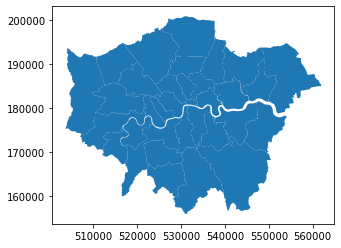

In [3]:
# Eva Richter
# This code calculates the spatially adoint items to the spatially adoint items of a designated area

# Import relevant modules: 
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import geopandas as gpd
import esda
import pysal as ps
import pysal.explore
import libpysal as lps
from libpysal.weights import Queen
import numpy as np
from esda.moran import Moran, Moran_Local
import fiona
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster
from esda.moran import Moran
from esda.moran import Moran_Local
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib as mpl


class SpatialNeighbors:
    """This class calculates spatial neighbors and neighbors of neighbors
    shapefile: GeoDataFrame of entire area
    ID: unique in the dataset"""
    def __init__(self, shapefile, ID):
        self.shapefile = shapefile 
        self.ID = ID
        
    def calculateNeighbors(self, core_area):
        # create spatial weighting matrix:
        w = lps.weights.Queen.from_dataframe(self.shapefile, idVariable=self.ID)
        w.transform = "R"
        neighbors_matrix = w[core_area]
        neighbors = [*neighbors_matrix] # transform dictionary into list
        return neighbors
    
    def NeighborsofNeighbors(self, core_area):
        # use previous function to calculate neighbors of core area
        n_list = self.calculateNeighbors(core_area)
        print(n_list)
        n_n_list = []
        # for each neighbor of the core area, we need a list of neighbors:
        for neighbor in n_list:
            n_n = self.calculateNeighbors(neighbor)
            for n_neighbor in n_n:
                if n_neighbor not in (n_list and n_n_list) and n_neighbor != core_area:
                    n_n_list.append(n_neighbor)
        return n_n_list
    

london = gpd.read_file("London_Borough_Excluding_MHW.shp")
london.plot()
london_n = SpatialNeighbors(london, "NAME")
n_n = london_n.NeighborsofNeighbors("Islington")
print(n_n)
